# Word2Vec with Visualizations

### What is Word2Vec & How to use Gensim

The idea behind Word2Vec is pretty simple. We are making and assumption that you can tell the meaning of a word by the company it keeps. This is analogous to the saying *show me your friends, and I'll tell who you are*. So if you have two words that have very similar neighbors (i.e. the usage context is about the same), then these words are probably quite similar in meaning or are at least highly related. For example, the words `shocked`,`appalled` and `astonished` are typically used in a similar context. 

In this tutorial, you will learn how to use the Gensim implementation of Word2Vec and actually get it to work! I have heard a lot of complaints about poor performance etc, but its really a combination of two things, (1) your input data and (2) your parameter settings. Note that the training algorithms in this package were ported from the [original Word2Vec implementation by Google](https://arxiv.org/pdf/1301.3781.pdf) and extended with additional functionality.

### Imports and logging

First, we start with our imports and get logging established:

In [1]:
# imports needed and set up logging
import gzip
import gensim
from gensim.utils import tokenize
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


C:\Users\connl\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Dataset 
Next, is our dataset. The secret to getting Word2Vec really working for you is to have lots and lots of text data. In this case I am going to use data from the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset. This dataset has full user reviews of cars and hotels. I have specifically concatenated all of the hotel reviews into one big file which is about 97MB compressed and 229MB uncompressed. We will use the compressed file for this tutorial. Each line in this file represents a hotel review. You can download the OpinRank Word2Vec dataset here.

To avoid confusion, while gensim’s word2vec tutorial says that you need to pass it a sequence of sentences as its input, you can always pass it a whole review as a sentence (i.e. a much larger size of text), and it should not make much of a difference. 

Now, let's take a closer look at this data below by printing the first line. You can see that this is a pretty hefty review.

In [3]:
data_file="data/reviews_data.txt.gz"

with gzip.open (data_file, 'rb') as f:
    for i,line in enumerate (f):
        print(line)
        break

b"Oct 12 2009 \tNice trendy hotel location not too bad.\tI stayed in this hotel for one night. As this is a fairly new place some of the taxi drivers did not know where it was and/or did not want to drive there. Once I have eventually arrived at the hotel, I was very pleasantly surprised with the decor of the lobby/ground floor area. It was very stylish and modern. I found the reception's staff geeting me with 'Aloha' a bit out of place, but I guess they are briefed to say that to keep up the coroporate image.As I have a Starwood Preferred Guest member, I was given a small gift upon-check in. It was only a couple of fridge magnets in a gift box, but nevertheless a nice gesture.My room was nice and roomy, there are tea and coffee facilities in each room and you get two complimentary bottles of water plus some toiletries by 'bliss'.The location is not great. It is at the last metro stop and you then need to take a taxi, but if you are not planning on going to see the historic sites in Be

### Read files into a list
Now that we've had a sneak peak of our dataset, we can read it into a list so that we can pass this on to the Word2Vec model. Notice in the code below, that I am directly reading the 
compressed file. I'm also doing a mild pre-processing of the reviews using `gensim.utils.simple_preprocess (line)`. This does some basic pre-processing such as tokenization, lowercasing, etc and returns back a list of tokens (words). Documentation of this pre-processing method can be found on the official [Gensim documentation site](https://radimrehurek.com/gensim/utils.html). 



In [4]:
def simple_preprocess(doc, deacc=False, min_len=2, max_len=15):
    """
    Convert a document into a list of tokens.

    This lowercases, tokenizes, de-accents (optional). -- the output are final
    tokens = unicode strings, that won't be processed any further.

    """
    tokens = [
        token for token in tokenize(doc, lower=True, deacc=deacc, errors='ignore')
        if min_len <= len(token) <= max_len and not token.startswith('_')
    ]
    return tokens

def read_input(input_file):
    """This method reads the input file which is in gzip format"""
    
    logging.info("reading file {0}...this may take a while".format(input_file))
    
    with gzip.open (input_file, 'rb') as f:
        for i, line in enumerate (f): 

            if (i%10000==0):
                logging.info ("read {0} reviews".format (i))
            # do some pre-processing and return a list of words for each review text
            yield simple_preprocess (line)

# read the tokenized reviews into a list
# each review item becomes a series of words
# so this becomes a list of lists
documents = list (read_input (data_file))
logging.info ("Done reading data file")    

2019-01-15 23:58:54,735 : INFO : reading file data/reviews_data.txt.gz...this may take a while
2019-01-15 23:58:54,737 : INFO : read 0 reviews
2019-01-15 23:58:56,247 : INFO : read 10000 reviews
2019-01-15 23:58:57,779 : INFO : read 20000 reviews
2019-01-15 23:58:59,553 : INFO : read 30000 reviews
2019-01-15 23:59:01,196 : INFO : read 40000 reviews
2019-01-15 23:59:03,004 : INFO : read 50000 reviews
2019-01-15 23:59:04,771 : INFO : read 60000 reviews
2019-01-15 23:59:06,373 : INFO : read 70000 reviews
2019-01-15 23:59:07,725 : INFO : read 80000 reviews
2019-01-15 23:59:09,150 : INFO : read 90000 reviews
2019-01-15 23:59:10,535 : INFO : read 100000 reviews
2019-01-15 23:59:11,904 : INFO : read 110000 reviews
2019-01-15 23:59:13,276 : INFO : read 120000 reviews
2019-01-15 23:59:14,688 : INFO : read 130000 reviews
2019-01-15 23:59:16,211 : INFO : read 140000 reviews
2019-01-15 23:59:17,599 : INFO : read 150000 reviews
2019-01-15 23:59:19,308 : INFO : read 160000 reviews
2019-01-15 23:59:2

## Training the Word2Vec model

Training the model is fairly straightforward. You just instantiate Word2Vec and pass the reviews that we read in the previous step (the `documents`). So, we are essentially passing on a list of lists. Where each list within the main list contains a set of tokens from a user review. Word2Vec uses all these tokens to internally create a vocabulary. And by vocabulary, I mean a set of unique words.

After building the vocabulary, we just need to call `train(...)` to start training the Word2Vec model. Training on the [OpinRank](http://kavita-ganesan.com/entity-ranking-data/) dataset takes about 10 minutes so please be patient while running your code on this dataset.

Behind the scenes we are actually training a simple neural network with a single hidden layer. But, we are actually not going to use the neural network after training. Instead, the goal is to learn the weights of the hidden layer. These weights are essentially the word vectors that we’re trying to learn. 

In [4]:
model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
model.train(documents,total_examples=len(documents),epochs=10)

2019-01-15 20:16:17,694 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-01-15 20:16:17,695 : INFO : collecting all words and their counts
2019-01-15 20:16:17,695 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-15 20:16:17,889 : INFO : PROGRESS: at sentence #10000, processed 1655714 words, keeping 25777 word types
2019-01-15 20:16:18,081 : INFO : PROGRESS: at sentence #20000, processed 3317863 words, keeping 35016 word types
2019-01-15 20:16:18,320 : INFO : PROGRESS: at sentence #30000, processed 5264072 words, keeping 47518 word types
2019-01-15 20:16:18,530 : INFO : PROGRESS: at sentence #40000, processed 7081746 words, keeping 56675 word types
2019-01-15 20:16:18,776 : INFO : PROGRESS: at sentence #50000, processed 9089491 words, keeping 63744 word types
2019-01-15 20:16:19,008 : INFO : PROGRESS: at sentence #60000, processed 11013726 words, keeping 76786 word types
2019-01-15 20:16:19,204 : INFO : PROGRESS: a

2019-01-15 20:16:49,094 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-01-15 20:16:49,095 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-01-15 20:16:49,096 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-01-15 20:16:49,097 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-15 20:16:49,098 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-15 20:16:49,099 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-15 20:16:49,103 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-15 20:16:49,103 : INFO : EPOCH - 2 : training on 41519358 raw words (30350342 effective words) took 12.7s, 2384843 effective words/s
2019-01-15 20:16:50,108 : INFO : EPOCH 3 - PROGRESS: at 7.46% examples, 2295445 words/s, in_qsize 20, out_qsize 0
2019-01-15 20:16:51,110 : INFO : EPOCH 3 - PROGRESS: at 14.28% examples, 2356296 words/s, in_qsize 19, out_q

2019-01-15 20:17:31,093 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-15 20:17:31,093 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-15 20:17:31,094 : INFO : EPOCH - 5 : training on 41519358 raw words (30348297 effective words) took 15.5s, 1951672 effective words/s
2019-01-15 20:17:31,094 : INFO : training on a 207596790 raw words (151750809 effective words) took 67.5s, 2247699 effective words/s
2019-01-15 20:17:31,094 : WARNING : Effective 'alpha' higher than previous training cycles
2019-01-15 20:17:31,094 : INFO : training model with 10 workers on 70537 vocabulary and 150 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
2019-01-15 20:17:32,109 : INFO : EPOCH 1 - PROGRESS: at 5.96% examples, 1818978 words/s, in_qsize 20, out_qsize 1
2019-01-15 20:17:33,109 : INFO : EPOCH 1 - PROGRESS: at 11.57% examples, 1872158 words/s, in_qsize 19, out_qsize 0
2019-01-15 20:17:34,113 : INFO : EPOCH 1 - PROGRESS: at 17.03% examples,

2019-01-15 20:18:20,033 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-01-15 20:18:20,038 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-01-15 20:18:20,039 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-01-15 20:18:20,042 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-01-15 20:18:20,043 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-01-15 20:18:20,044 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-01-15 20:18:20,046 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-01-15 20:18:20,047 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-01-15 20:18:20,047 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-01-15 20:18:20,052 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-01-15 20:18:20,053 : INFO : EPOCH - 3 : training on 41519358 raw words (30349568 effe

2019-01-15 20:19:06,436 : INFO : EPOCH 6 - PROGRESS: at 73.06% examples, 1708883 words/s, in_qsize 20, out_qsize 0
2019-01-15 20:19:07,440 : INFO : EPOCH 6 - PROGRESS: at 78.37% examples, 1703602 words/s, in_qsize 19, out_qsize 0
2019-01-15 20:19:08,442 : INFO : EPOCH 6 - PROGRESS: at 84.07% examples, 1705456 words/s, in_qsize 19, out_qsize 0
2019-01-15 20:19:09,447 : INFO : EPOCH 6 - PROGRESS: at 90.16% examples, 1708632 words/s, in_qsize 20, out_qsize 0
2019-01-15 20:19:10,452 : INFO : EPOCH 6 - PROGRESS: at 96.30% examples, 1712962 words/s, in_qsize 19, out_qsize 0
2019-01-15 20:19:11,028 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-01-15 20:19:11,033 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-01-15 20:19:11,034 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-01-15 20:19:11,034 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-01-15 20:19:11,036 : INFO : worker thread finished; awai

2019-01-15 20:19:51,806 : INFO : EPOCH 9 - PROGRESS: at 31.53% examples, 1719346 words/s, in_qsize 20, out_qsize 1
2019-01-15 20:19:52,806 : INFO : EPOCH 9 - PROGRESS: at 37.53% examples, 1722125 words/s, in_qsize 18, out_qsize 1
2019-01-15 20:19:53,809 : INFO : EPOCH 9 - PROGRESS: at 43.88% examples, 1725150 words/s, in_qsize 20, out_qsize 0
2019-01-15 20:19:54,811 : INFO : EPOCH 9 - PROGRESS: at 49.92% examples, 1723503 words/s, in_qsize 19, out_qsize 0
2019-01-15 20:19:55,811 : INFO : EPOCH 9 - PROGRESS: at 55.84% examples, 1725570 words/s, in_qsize 19, out_qsize 0
2019-01-15 20:19:56,819 : INFO : EPOCH 9 - PROGRESS: at 61.71% examples, 1723220 words/s, in_qsize 19, out_qsize 1
2019-01-15 20:19:57,832 : INFO : EPOCH 9 - PROGRESS: at 67.82% examples, 1722891 words/s, in_qsize 20, out_qsize 1
2019-01-15 20:19:58,839 : INFO : EPOCH 9 - PROGRESS: at 73.32% examples, 1716890 words/s, in_qsize 18, out_qsize 2
2019-01-15 20:19:59,840 : INFO : EPOCH 9 - PROGRESS: at 78.82% examples, 1716492

(303489298, 415193580)

## Now, let's look at some output 
This first example shows a simple case of looking up words similar to the word `dirty`. All we need to do here is to call the `most_similar` function and provide the word `dirty` as the positive example. This returns the top 10 similar words. 

In [5]:

w1 = "starbucks"
model.wv.most_similar (positive=w1)


2019-01-15 20:20:20,570 : INFO : precomputing L2-norms of word weight vectors


[('starbuck', 0.8290931582450867),
 ('mcdonalds', 0.7283457517623901),
 ('deli', 0.7166962623596191),
 ('shop', 0.7040393352508545),
 ('mcdonald', 0.682826578617096),
 ('dunkin', 0.6689075827598572),
 ('costa', 0.6648142337799072),
 ('cafe', 0.657538115978241),
 ('pret', 0.6528072357177734),
 ('walgreens', 0.6523852348327637)]

That looks pretty good, right? Let's look at a few more. Let's look at similarity for `polite`, `france` and `shocked`. 

In [6]:
# look up top 6 words similar to 'polite'
w1 = ["polite"]
model.wv.most_similar (positive=w1,topn=6)


[('courteous', 0.9231535792350769),
 ('friendly', 0.8314815759658813),
 ('professional', 0.7954604625701904),
 ('cordial', 0.787022590637207),
 ('attentive', 0.78354811668396),
 ('gracious', 0.7435349225997925)]

In [7]:
# look up top 6 words similar to 'france'
w1 = ["france"]
model.wv.most_similar (positive=w1,topn=6)


[('spain', 0.6547222137451172),
 ('canada', 0.6489040851593018),
 ('germany', 0.6422605514526367),
 ('england', 0.6341640949249268),
 ('barcelona', 0.6009808778762817),
 ('usa', 0.5775949954986572)]

In [8]:
# look up top 6 words similar to 'shocked'
w1 = ["shocked"]
model.wv.most_similar (positive=w1,topn=6)


[('horrified', 0.8145856261253357),
 ('amazed', 0.7887231111526489),
 ('dismayed', 0.7690994143486023),
 ('astonished', 0.7679455876350403),
 ('appalled', 0.7632206678390503),
 ('stunned', 0.7432228922843933)]

That's, nice. You can even specify several positive examples to get things that are related in the provided context and provide negative examples to say what should not be considered as related. In the example below we are asking for all items that *relate to bed, sheet, and pillow* only:

In [9]:
# get everything related to stuff on the bed
w1 = ["bed",'sheet','pillow']
w2 = ['couch']
model.wv.most_similar (positive=w1,negative=w2,topn=10)


[('duvet', 0.7167655825614929),
 ('mattress', 0.7008334398269653),
 ('quilt', 0.6916956901550293),
 ('blanket', 0.6833271980285645),
 ('matress', 0.6771711707115173),
 ('sheets', 0.6487412452697754),
 ('pillowcase', 0.6471561193466187),
 ('pillows', 0.6358782649040222),
 ('foam', 0.6241512894630432),
 ('comforter', 0.6136789321899414)]

### Similarity between two words in the vocabulary

You can even use the Word2Vec model to return the similarity between two words that are present in the vocabulary. 

In [10]:
# similarity between two different words
model.wv.similarity(w1="dirty",w2="smelly")

0.742739160977651

In [11]:
# similarity between two identical words
model.wv.similarity(w1="dirty",w2="dirty")

1.0

In [12]:
# similarity between two unrelated words
model.wv.similarity(w1="dirty",w2="clean")

0.26348759296520763

Under the hood, the above three snippets computes the cosine similarity between the two specified words using word vectors of each. From the scores, it makes sense that `dirty` is highly similar to `smelly` but `dirty` is dissimilar to `clean`. If you do a similarity between two identical words, the score will be 1.0 as the range of the cosine similarity score will always be between [0.0-1.0]. You can read more about cosine similarity scoring [here](https://en.wikipedia.org/wiki/Cosine_similarity).

### Find the odd one out
You can even use Word2Vec to find odd items given a list of items.

In [13]:
# Which one is the odd one out in this list?
model.wv.doesnt_match(["cat","dog","france"])

'france'

In [14]:
# Which one is the odd one out in this list?
model.wv.doesnt_match(["bed","pillow","duvet","shower"])


'shower'

## Understanding some of the parameters
To train the model earlier, we had to set some parameters. Now, let's try to understand what some of them mean. For reference, this is the command that we used to train the model.

```
model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
```

### `size`
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100-150 has worked well for me. 

### `window`
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window. 

### `min_count`
Minimium frequency count of words. The model would ignore words that do not statisfy the `min_count`. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

### `workers`
How many threads to use behind the scenes?


## When should you use Word2Vec?

There are many application scenarios for Word2Vec. Imagine if you need to build a sentiment lexicon. Training a Word2Vec model on large amounts of user reviews helps you achieve that. You have a lexicon for not just sentiment, but for most words in the vocabulary. 

Beyond, raw unstructured text data, you could also use Word2Vec for more structured data. For example, if you had tags for a million stackoverflow questions and answers, you could find tags that are related to a given tag and recommend the related ones for exploration. You can do this by treating each set of co-occuring tags as a "sentence" and train a Word2Vec model on this data. Granted, you still need a large number of examples to make it work. 


In [15]:
# visualize data
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show
from bokeh.io import push_notebook, output_notebook
from bokeh.models import ColumnDataSource, LabelSet
import re
import sys
import pandas as pd

X = gensim.utils.sample_dict(model.wv.vocab, n=2000, use_random=True)
values = []
embed = []

for i in range(len(X)):
    spool = X[i][:1]
    clean = str(spool).replace('(', '').replace(')', '').replace('\'', '').replace(',', '')
    values.append(clean)
    vector = model.wv.word_vec(values[i], use_norm=True)
    embed.append(vector)
    
#print(values)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(embed)

In [16]:
def interactive_tsne(text_labels, tsne_array):
    '''makes an interactive scatter plot with text labels for each point'''

    # define a dataframe to be used by bokeh context
    bokeh_df = pd.DataFrame(tsne_array, text_labels, columns=['x','y'])
    bokeh_df['text_labels'] = bokeh_df.index

    # interactive controls to include to the plot
    TOOLS="hover, zoom_in, zoom_out, box_zoom, undo, redo, reset, box_select"

    p = figure(tools=TOOLS, plot_width=800, plot_height=700)
    
    # define data source for the plot
    source = ColumnDataSource(bokeh_df)

    # scatter plot
    p.scatter('x', 'y', source=source, fill_alpha=0.6,
              fill_color="#8724B5",
              line_color=None)

    # text labels
    labels = LabelSet(x='x', y='y', text='text_labels', y_offset=8,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')

    p.add_layout(labels)

    # show plot inline
    output_notebook()
    show(p)

In [17]:
interactive_tsne(values, X_tsne)

Loading BokehJS ...

In [ ]:
model.wv.save_word2vec_format('w2v-test', binary=False)

In [19]:
# for interactive plots (optional)
import ipympl
# needs: conda install ipympl -c conda-forge

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# regular notebook
# %matplotlib notebook
# regular notebook inline
%matplotlib inline
# interactive plots
# %matplotlib ipympl

def plot_words_2d(vectors, words, plot = True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(vectors[:,0], vectors[:,1], marker='.')
    for i, word in enumerate(words):
        ax.text(x=vectors[i,0], y=vectors[i,1], s=word)
    if plot:
        plt.show()
    return plt;  

def plot_words_3d(vectors, words, plot = True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vectors[:,0], vectors[:,1], vectors[:,2], marker='.')
    for i, word in enumerate(words):
        ax.text(x=vectors[i,0], y=vectors[i,1], z=vectors[i,2], s=word)
    if plot:
        plt.show()
    return plt;

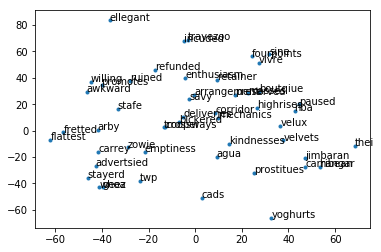

In [20]:
from sklearn.manifold import TSNE
import numpy as np

# Project the words in 2D space
model = TSNE(n_components=2, random_state=0, perplexity=15)
if True:
    X_tsne_2d = model.fit_transform(X_tsne)
    # save for later
    np.savetxt('data/tsne_2d.txt', X_tsne_2d);
else:
    print("WARNING: loading stale vectors from tsne_2d.txt")
    X_tsne_2d = np.loadtxt('data/tsne_2d.txt');

# show first 20 points
npts = 50
plot_words_2d(X_tsne_2d[0:npts,:], values[0:npts]);

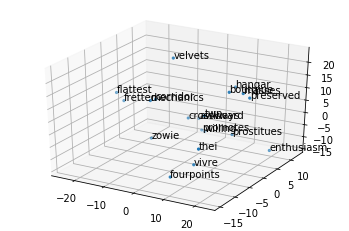

In [21]:
# Project the words in 3D space
model = TSNE(n_components=3, random_state=0, perplexity=15)
if True:
    X_tsne_3d = model.fit_transform(X_tsne_2d)
    # save for later
    np.savetxt('data/tsne_3d.txt', X_tsne_3d);
else:
    print("WARNING: loading stale vectors from tsne_3d.txt")
    X_tsne_3d = np.loadtxt('data/tsne_3d.txt');
    
npts = 20
plot_words_3d(X_tsne_3d[0:npts,0:3], values[0:npts]);

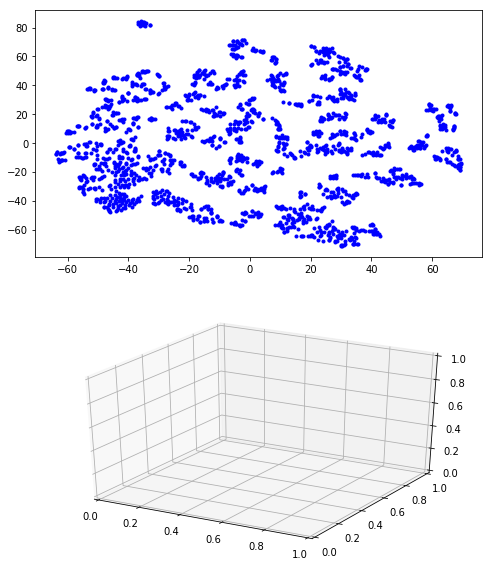

In [22]:
from sklearn.neighbors import NearestNeighbors

# show interactive 2D plot like in Tensorboard
def plot_words_2d_interactive(vectors, words, plot = True, n_neighbors = 15, vectors_3d = None):
    fig = plt.figure(figsize=(8,10))
    ax = fig.add_subplot(211)
    if vectors_3d is None:
        ax_zoom = fig.add_subplot(212)
    else:
        ax_zoom = fig.add_subplot(212, projection='3d')
    ax.scatter(vectors[:,0], vectors[:,1], marker='.', c='b')
    if plot:
        plt.show()
    
    NN_model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(vectors)
    last_indices = None
    
    def onclick_2d_interactive(event):
        # print('button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata))

        if event.inaxes == ax_zoom:
            return;
        
        distances, indices = NN_model.kneighbors([[event.xdata, event.ydata]], n_neighbors=n_neighbors)
        # distances, indices = NN_model.radius_neighbors([[event.xdata, event.ydata]], radius=0.5)
        # print(indices)
        
        indices = indices[0]
        if indices.size == 0:
            return
        ax_zoom.clear()
        if vectors_3d is None:
            ax_zoom.scatter(vectors[indices,0], vectors[indices,1], marker='.')
            for i in indices:
                ax_zoom.text(x=vectors[i,0], y=vectors[i,1], s=words[i])
        else:
            ax_zoom.scatter(vectors_3d[indices,0], vectors_3d[indices,1], vectors_3d[indices,2], marker='.')
            for i in indices:
                ax_zoom.text(x=vectors_3d[i,0], y=vectors_3d[i,1], z=vectors_3d[i,2], s=words[i])
        # highlight on main plot
        nonlocal last_indices
        if last_indices is not None:
            ax.scatter(vectors[last_indices,0], vectors[last_indices,1], marker='.', c='b')
        ax.scatter(vectors[indices,0], vectors[indices,1], marker='.', c='g')
        last_indices = indices

    cid = fig.canvas.mpl_connect('button_press_event', onclick_2d_interactive)
    return plt

plt.close("all")
npts = 5000
plot_words_2d_interactive(X_tsne_2d[0:npts,0:2], values[0:npts], vectors_3d = X_tsne_3d);

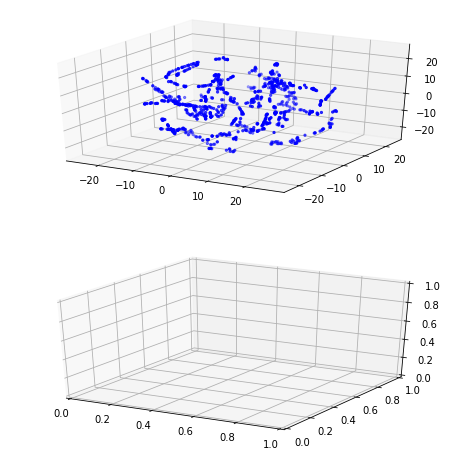

In [23]:
from sklearn.neighbors import NearestNeighbors

ev = None

# show interactive 3D plot like in Tensorboard
def plot_words_3d_interactive(vectors, words, plot = True, n_neighbors = 15):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(211, projection='3d')
    ax_zoom = fig.add_subplot(212, projection='3d')
    ax.scatter(vectors[:,0], vectors[:,1], vectors[:,2], marker='.', c='b', picker=3)
    if plot:
        plt.show()
    
    NN_model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(vectors)
    last_indices = None
    
    def onclick_3d_interactive(event):
        _x, _y, _z = event.artist._offsets3d
        ind = event.ind[0]
        x = _x[ind]
        y = _y[ind]
        z = _z[ind]
        # print(x, y, z)
        distances, indices = NN_model.kneighbors([[x, y, z]], n_neighbors=n_neighbors)
        # distances, indices = NN_model.radius_neighbors([[event.xdata, event.ydata]], radius=0.5)
        # print(indices)
        distances = distances[0]
        indices = indices[0]
        if indices.size == 0:
            return

        avg_neighbor = np.mean(distances[1:6])
        keep = distances>2*avg_neighbor
        distance = distances[keep]
        indices = indices[keep]
        
        ax_zoom.clear()
        ax_zoom.scatter(vectors[indices,0], vectors[indices,1], vectors[indices,2], marker='.')
        for i in indices:
            jitter = 0 #0.5 * np.random.rand(1,1)
            ax_zoom.text(x=vectors[i,0], y=vectors[i,1], z=vectors[i,2]+jitter, s=words[i])
        # highlight on main plot
#         nonlocal last_indices
#         if last_indices is not None:
#             ax.scatter(vectors[last_indices,0], vectors[last_indices,1], marker='.', c='b')
#         ax.scatter(vectors[indices,0], vectors[indices,1], marker='.', c='g')
#         last_indices = indices

    cid = fig.canvas.mpl_connect('pick_event', onclick_3d_interactive)
    return plt

plt.close("all")
npts = 1000
plot_words_3d_interactive(X_tsne_3d[0:npts,0:3], values[0:npts], plot=True);